In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

from utils import *
from model.loss import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
symsim_r1b1 = endoRNA_noIAC(standardize=False)
symsim_r1b2 = endoATAC_noIAC(standardize=False)

symsim_r1b1_CONFIG = { 
    'in_features': 500,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 32,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

symsim_r1b2_CONFIG = { 
    'in_features': 128,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 32,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}


train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_r1b1_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_r1b2_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    Diff1 = diff.phate_similarity(data["raw"], 
                                  n_neigh = 5, 
                                  t = 10, 
                                  use_potential = True)
    
    DPT1 = diff.DPT_similarity(data["raw"], 
                               n_neigh = 5, 
                               use_potential = True)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    
    DPT1 = torch.FloatTensor(DPT1).to(device)


for data in test_r1b2_loader:
    Diff2 = diff.phate_similarity(data["raw"], 
                                  n_neigh = 5, 
                                  t = 10, 
                                  use_potential = True)
    
    DPT2 = diff.DPT_similarity(data["raw"], 
                               n_neigh = 5, 
                               use_potential = True)
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    
    DPT2 = torch.FloatTensor(DPT2).to(device)

In [30]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b1_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b1_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b2_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b2_CONFIG))
      ])).to(device)

disc = ae.discriminator().to(device)

optimizer_rna = torch.optim.Adam(ae1.parameters(), lr = 5e-4)
optimizer_atac = torch.optim.Adam(ae2.parameters(), lr = 5e-4)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 5e-4)

In [31]:
train_unpaired(ae1, ae2, disc, train_r1b1_loader, train_r1b2_loader, Diff1, Diff2, optimizer_rna, optimizer_atac, optimizer_D, n_epochs=101, n_iter=15,  lamb_r_rna = 0, lamb_r_atac = 0)

epoch:  0 RNA loss: -0.56723, RNA recon loss: 0.36447, RNA dist loss: -0.93170 ATAC loss: -0.51294, ATAC recon loss: 0.43799, ATAC dist loss: -0.95093 Discriminator loss: 0.57243
epoch:  10 RNA loss: -0.78277, RNA recon loss: 0.19211, RNA dist loss: -0.97488 ATAC loss: -0.76255, ATAC recon loss: 0.22543, ATAC dist loss: -0.98797 Discriminator loss: 0.62861
epoch:  20 RNA loss: -0.82902, RNA recon loss: 0.15900, RNA dist loss: -0.98802 ATAC loss: -0.74828, ATAC recon loss: 0.24637, ATAC dist loss: -0.99465 Discriminator loss: 0.65008
epoch:  30 RNA loss: -0.84201, RNA recon loss: 0.13963, RNA dist loss: -0.98164 ATAC loss: -0.72019, ATAC recon loss: 0.25987, ATAC dist loss: -0.98006 Discriminator loss: 0.62398
epoch:  40 RNA loss: -0.84114, RNA recon loss: 0.13481, RNA dist loss: -0.97595 ATAC loss: -0.80475, ATAC recon loss: 0.18970, ATAC dist loss: -0.99445 Discriminator loss: 0.67411
epoch:  50 RNA loss: -0.85240, RNA recon loss: 0.12736, RNA dist loss: -0.97976 ATAC loss: -0.72346, 

In [34]:
# torch.save({
#     'ae1': ae1.state_dict(),
#     'optim_ae1': optimizer_rna.state_dict(),
#     'ae2': ae2.state_dict(),
#     'optim_ae2': optimizer_rna.state_dict(),
#     'disc': disc.state_dict(),
#     'optim_disc': optimizer_D.state_dict(),
#     'config1': symsim_r1b1_CONFIG,
#     'config2': symsim_r1b2_CONFIG,
#     'phate_t': 10,
#     'phate_neigh': 5
# }, './saved_model/endo_phate_3.pt')

In [35]:
state = torch.load('./saved_model/endo_phate_3.pt')

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b1_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b1_CONFIG))
      ])).to(device)
ae1.load_state_dict(state['ae1'])

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b2_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b2_CONFIG))
      ])).to(device)
ae2.load_state_dict(state['ae2'])

disc = ae.discriminator().to(device)
disc.load_state_dict(state['disc'])

<All keys matched successfully>

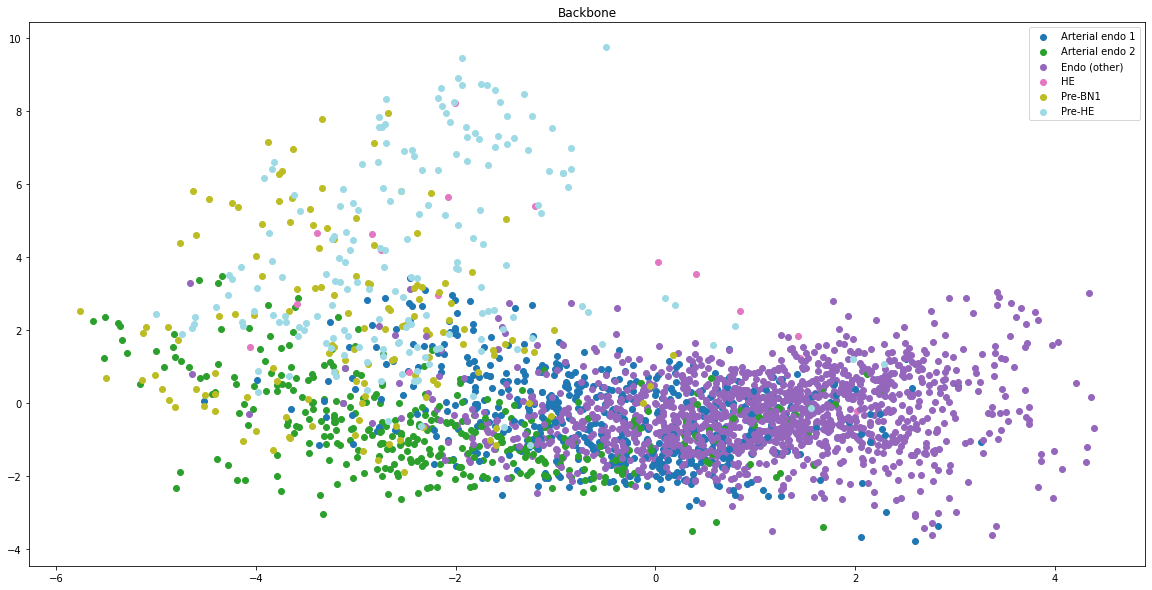

In [40]:
ae1.eval()
ae2.eval()

for data in test_r1b1_loader:
    ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

for data in test_r1b2_loader:
    ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "joint",save = None)


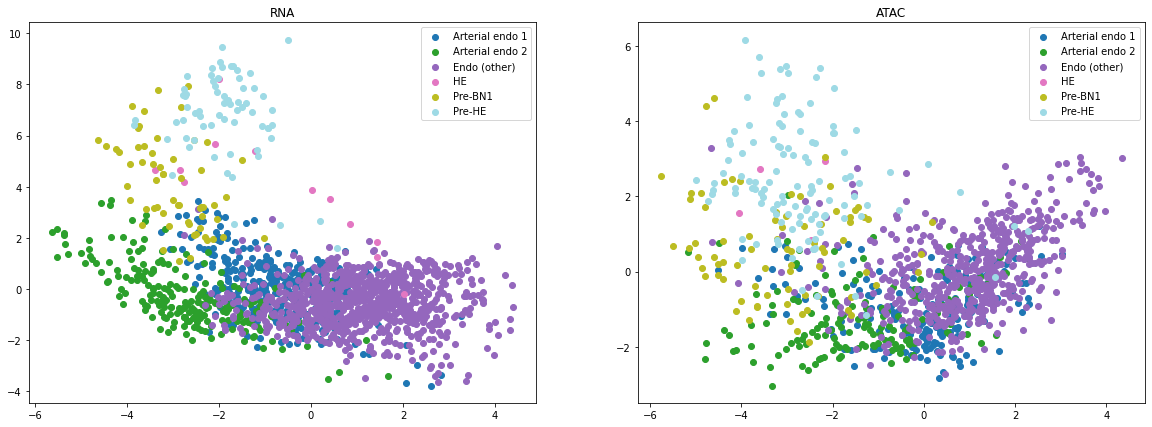

In [41]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = None)

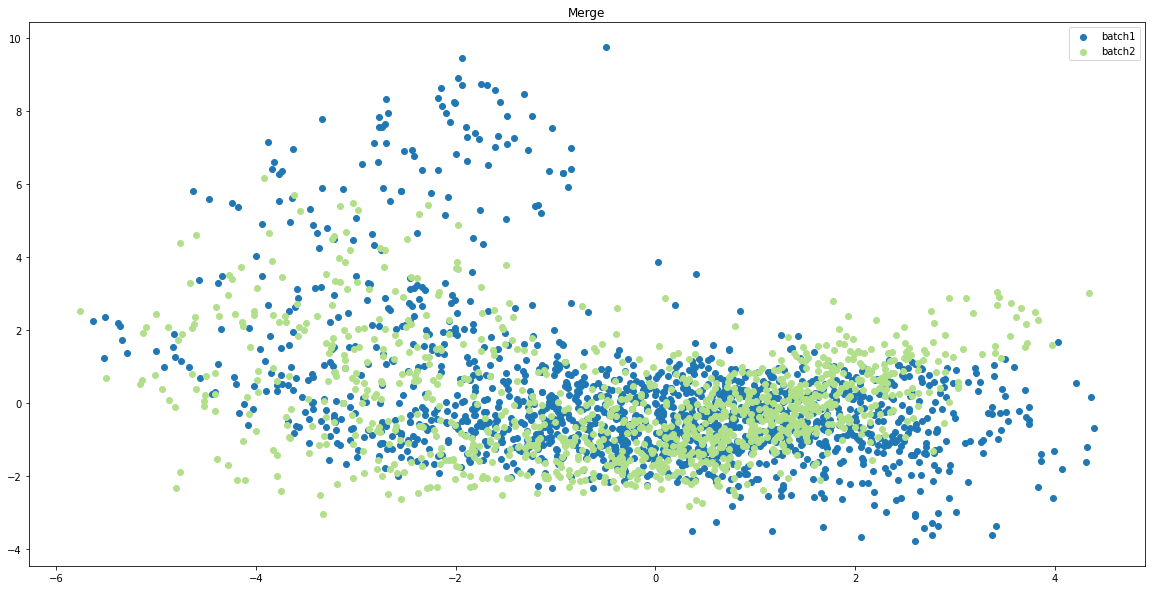

In [42]:
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "modality",save = None)